In [1]:
# Test Policy 1: vax 1x / wk, unvax 2x / wk

In [2]:
import sys
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
module_path = os.path.abspath(os.path.join('../../..'))
if module_path + "/src/simulations_v2" not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
    
from load_params import load_params
from analysis_helpers import get_cumulative_infection_cols

from multi_group_simulation import MultiGroupSimulation
from vax_sim_utils import load_vax_group_configs, create_multigrp_vax_sim, process_vax_config

In [3]:
def load_vax_config(vac_perc, test_policy):
    # load vax config
    with open(os.getcwd() + "/../vax_sim_nominal_params/ug_greek_athlete_vax_config.yaml", "rb") as f:
        UG_GA_vax_config = yaml.load(f)
    with open(os.getcwd() + "/../vax_sim_nominal_params/ug_other_vax_config.yaml", "rb") as f:
        UG_other_vax_config = yaml.load(f)
    
    # process vax config
    UG_GA_vax_config['vax_proportion'] = vac_perc
    UG_GA_vax_config['vax_test_freq'] = test_policy[0]
    UG_GA_vax_config['unvax_test_freq'] = test_policy[1]
    UG_GA_vax_config = process_vax_config(UG_GA_vax_config)
    
    UG_other_vax_config['vax_proportion'] = vac_perc
    UG_other_vax_config['vax_test_freq'] = test_policy[0]
    UG_other_vax_config['unvax_test_freq'] = test_policy[1]
    UG_other_vax_config = process_vax_config(UG_other_vax_config)
    
    return UG_GA_vax_config, UG_other_vax_config


def get_sim(contact_mult, UG_GA_vax_config, UG_other_vax_config):
    contact_matrix = 10 * np.array([[92/125, 1/44],
                               [3.5/125, 6.5/44]]) # Calibrated contact matrix for UG groups

    UG_group_params = UG_GA_vax_config[0] + UG_other_vax_config[0]
    UG_vax_status = UG_GA_vax_config[1] + UG_other_vax_config[1]
    GA_vax_perc = UG_GA_vax_config[0][0]['population_size'] / (UG_GA_vax_config[0][0]['population_size'] + UG_GA_vax_config[0][1]['population_size'])
    other_vax_perc = UG_other_vax_config[0][0]['population_size'] / (UG_other_vax_config[0][0]['population_size'] + UG_other_vax_config[0][1]['population_size'])
    UG_contact_matrix = np.zeros((4,4))

    for row in range(4):
        if row < 2:
            UG_contact_matrix[row,:] = 10 * np.array([92/125 * GA_vax_perc, 92/125 * (1-GA_vax_perc), 1/44 * other_vax_perc, 1/44 * (1-other_vax_perc)])
        else:
            UG_contact_matrix[row,:] = 10 * np.array([3.5/125 * GA_vax_perc, 3.5/125 * (1-GA_vax_perc), 6.5/44 * other_vax_perc, 6.5/44 * (1-other_vax_perc)])

    # Double contacts per day
    UG_contact_matrix *= contact_mult
    for i in range(4):
        UG_group_params[i]['expected_contacts_per_day'] = UG_contact_matrix[i,i]
        
    return UG_group_params, UG_vax_status, UG_contact_matrix

def get_case_counts(sim, N=25, T=112):
    inf_count = list()
    cum_inf_cols = get_cumulative_infection_cols(sim.run_new_trajectory(T=1)[1])
    for _ in range(N):
        inf_count.append(np.array(sim.run_new_trajectory(T)[1][cum_inf_cols].sum(axis=1))[-1])
    return np.quantile(inf_count, 0.5)


def get_contour_inf(contact_rate_mult, vac_perc, test_policy):
    UG_GA_vax_config, UG_other_vax_config = load_vax_config(vac_perc, test_policy)
    UG_group_params, UG_vax_status, UG_contact_matrix = get_sim(contact_rate_mult, UG_GA_vax_config, UG_other_vax_config)
    sim = create_multigrp_vax_sim(UG_group_params, UG_vax_status, UG_contact_matrix, 0.5, 0.21)
    median_inf = get_case_counts(sim)
    return median_inf

In [4]:
contacts_per_day_mults = np.linspace(1,3,7)
vax_percs = np.linspace(0.7,1,7)

test_policy = [1/7, 2/7]

Zs_inf = []

np.random.seed(2021)

for contact_mult in contacts_per_day_mults:
    Z_inf = []
    for vax_perc in vax_percs:
        Z_inf.append(get_contour_inf(contact_mult, vax_perc, test_policy))
    Zs_inf.append(Z_inf)

/home/aaj54/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.
/home/aaj54/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_

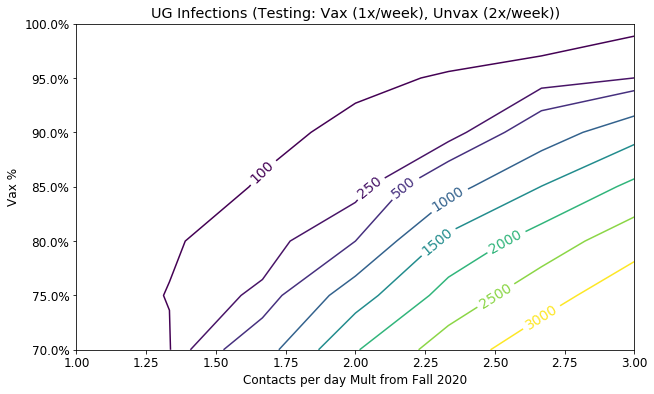

In [5]:
plt.figure(figsize=(10,6))
plt.title("UG Infections (Testing: Vax (1x/week), Unvax (2x/week))")
plt.ylabel("Vax %")
plt.xlabel("Contacts per day Mult from Fall 2020")
# X,Y = np.meshgrid(trans_mult_vac, contact_rate_mult)
# CS = plt.contour(X, Y, np.array(Zs_inf).T)
CS = plt.contour(np.array(contacts_per_day_mults), 100*np.array(vax_percs), np.array(Zs_inf).T, levels=[100, 250, 500, 1000, 1500, 2000, 2500, 3000])
plt.clabel(CS, inline=1, fmt='%d', fontsize=14)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

In [6]:
Zs_inf

[[57.0, 56.0, 49.0, 41.0, 38.0, 28.0, 26.0],
 [92.0, 103.0, 91.0, 46.0, 47.0, 37.0, 23.0],
 [794.0, 294.0, 144.0, 109.0, 76.0, 41.0, 30.0],
 [1965.0, 1277.0, 500.0, 149.0, 122.0, 81.0, 38.0],
 [2753.0, 2187.0, 1630.0, 821.0, 133.0, 108.0, 41.0],
 [3299.0, 2802.0, 2229.0, 1508.0, 740.0, 137.0, 46.0],
 [3780.0, 3319.0, 2808.0, 2116.0, 1324.0, 251.0, 55.0]]